## IMPORTING REQUIRED PACKAGES

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

## DATA LOADING AND PRE-PROCESSING

In [2]:
# path => address of folder with images
# urls => list of names of images inside the folder
# target => target label for images

def loadImages(path, urls, target):
    images = []
    labels = []
    for i in range(len(urls)):
        img_path = path + urls[i]
        img = cv2.imread(img_path)
        img = img / 255.0   # normalisation of images
        img = cv2.resize(img, (100, 100))  # to resize the images
        images.append(img)
        labels.append(target)
    images = np.asarray(images)  # converting list to numpy array as it offers more functionality
    return images, labels

In [3]:
covid_path = "Covid-19_Radiography_Dataset\\COVID\\images\\"
covid_url = os.listdir("Covid-19_Radiography_Dataset\\COVID\\images\\")
covidImages, covidTargets = loadImages(covid_path, covid_url, 1)

viral_path = "Covid-19_Radiography_Dataset\\Viral Pneumonia\\images\\"
viral_url = os.listdir("Covid-19_Radiography_Dataset\\Viral Pneumonia\\images\\")
viralImages, viralTargets = loadImages(viral_path, viral_url, 2)

normal_path = "Covid-19_Radiography_Dataset\\Normal\\images\\"
normal_url = os.listdir("Covid-19_Radiography_Dataset\\Normal\\images\\")
normalImages, normalTargets = loadImages(normal_path, normal_url, 0)

In [4]:
data = np.r_[covidImages, viralImages, normalImages]

targets = np.r_[covidTargets, viralTargets, normalTargets]

data.shape, targets.shape

((15153, 100, 100, 3), (15153,))

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size = 0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.125)

In [6]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(10606, 100, 100, 3) (10606,)
(1516, 100, 100, 3) (1516,)
(3031, 100, 100, 3) (3031,)


## BUILDING A MODEL

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(100, 100, 3), activation = 'relu', kernel_regularizer=regularizers.l2(l=0.01), kernel_initializer='he_normal'),
    MaxPooling2D(),
    Dropout(0.4),
    Conv2D(16, (3, 3), activation = 'relu', kernel_regularizer=regularizers.l2(l=0.01)),
    MaxPooling2D(),
    Dropout(0.4),
    Conv2D(16, (3, 3), activation = 'relu', kernel_regularizer=regularizers.l2(l=0.01)),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(3, activation = 'softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 23, 23, 16)        0

In [9]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])

## TRAINING THE MODEL

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

model.fit(x_train, y_train, batch_size = 64, epochs = 50, validation_data = (x_val, y_val), callbacks = [callback])

Epoch 1/50
166/166 [==============================] - 103s 595ms/step - loss: 1.6237 - accuracy: 0.6792 - val_loss: 1.4173 - val_accuracy: 0.7375
Epoch 2/50
166/166 [==============================] - 92s 554ms/step - loss: 1.0733 - accuracy: 0.7468 - val_loss: 1.1436 - val_accuracy: 0.7810
Epoch 3/50
166/166 [==============================] - 98s 593ms/step - loss: 0.8603 - accuracy: 0.7787 - val_loss: 0.9315 - val_accuracy: 0.7573
Epoch 4/50
166/166 [==============================] - 94s 568ms/step - loss: 0.7120 - accuracy: 0.8045 - val_loss: 0.7609 - val_accuracy: 0.8199
Epoch 5/50
166/166 [==============================] - 84s 505ms/step - loss: 0.6013 - accuracy: 0.8276 - val_loss: 0.6189 - val_accuracy: 0.8509
Epoch 6/50
166/166 [==============================] - 86s 520ms/step - loss: 0.5143 - accuracy: 0.8492 - val_loss: 0.5632 - val_accuracy: 0.8555
Epoch 7/50
166/166 [==============================] - 81s 486ms/step - loss: 0.4646 - accuracy: 0.8573 - val_loss: 0.4802 - val_a

In [11]:
model.save("Covid19_CNN_3.h5")

## ACCURACY & LOSS FOR MODEL

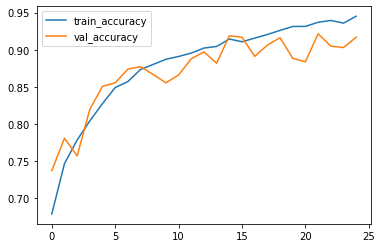

In [12]:
plt.plot(model.history.history['accuracy'], label = 'train_accuracy')
plt.plot(model.history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

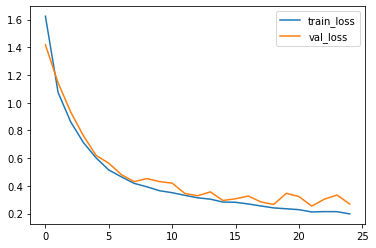

In [13]:
plt.plot(model.history.history['loss'], label = 'train_loss')
plt.plot(model.history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

## TESTING THE MODEL

In [14]:
rerun_model = load_model("Covid19_CNN_3.h5")

y_pred = rerun_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)

95/95 [==============================] - 6s 53ms/step


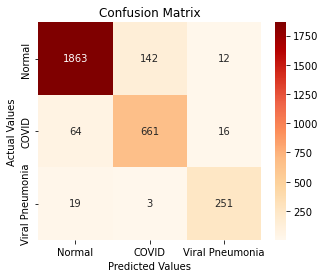

In [16]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['Normal','COVID','Viral Pneumonia'], 
                     columns = ['Normal','COVID','Viral Pneumonia'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap="OrRd", fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [15]:
accuracy_score(y_test, y_pred)

0.9155394259320356